# BBCA Stock Price Prediction Model

## Project Background
Stock price prediction is a significant area of interest in financial markets. It involves using historical price data and machine learning techniques to forecast future stock prices. BBCA is a popular stock price of Bank Central Asia owned by many investors. By creating a prediction model, it'll hopefully minimizes risk for these investors. However, predicting stock price isn't easy. Out of many machine learning models, Long Short Term Memory (LSTM) is said to be the most suitable model to be used in this case. 

## Objectives
- Build machine learning models to forecast BBCA future prices.
- Evaluate each models and choose the best model.

## Dataset
In this project, we use the monthly historical stock prices of Bank Central Asia (BBCA) from January 1, 2015 to January 1, 2025, with the column descriptions provided below.

- Price: The closing price of the stock
- Open: The opening price of the stock
- High: The highest price of the stock
- Low: The lowest price of the stock
- Volume: The total number of shares traded in a single day

In [22]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Import Data

In [23]:
# load dataset
stock_data = pd.read_csv("bbca.csv")
stock_data

,Date,Price,Open,High,Low,Vol.,Change %
0,03/18/2025,"8,200","8,525","8,550","8,075",202.71M,-4.65%
1,03/17/2025,"8,600","8,750","8,775","8,550",151.37M,-1.71%
2,03/14/2025,"8,750","8,800","8,925","8,750",111.40M,-2.51%
3,03/13/2025,"8,975","9,150","9,175","8,975",83.03M,-1.64%
4,03/12/2025,"9,125","9,025","9,125","8,975",87.97M,2.24%
...,...,...,...,...,...,...,...
1257,01/08/2020,"6,680","6,670","6,745","6,670",53.69M,-0.89%
1258,01/07/2020,"6,740","6,735","6,770","6,730",45.02M,0.07%
1259,01/06/2020,"6,735","6,720","6,750","6,690",27.30M,-0.96%
1260,01/03/2020,"6,800","6,750","6,800","6,725",47.76M,1.64%


In [24]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1262 non-null   object
 1   Price     1262 non-null   object
 2   Open      1262 non-null   object
 3   High      1262 non-null   object
 4   Low       1262 non-null   object
 5   Vol.      1262 non-null   object
 6   Change %  1262 non-null   object
dtypes: object(7)
memory usage: 69.1+ KB


In [25]:
# check duplicates and null value
def check_data(dataset):
    print(f"Number of duplicates: {dataset.duplicated().sum()}")
    print(f"Number of null values: {dataset.isnull().sum().sum()}")
    
check_data(stock_data)

Number of duplicates: 0
Number of null values: 0


In [26]:
# convert into datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')

# change column name 'Price' into 'Close' for clarity
stock_data.rename(columns={'Price': 'Close'}, inplace=True)

# standardize data
def parse_numeric(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value)
    return value

# Apply numeric conversion to relevant columns
for column in ['Open', 'High', 'Low', 'Close', 'Vol.']:
    if column in stock_data.columns:
        stock_data[column] = stock_data[column].apply(parse_numeric)

# Rename 'Vol.' to 'Volume' for clarity
stock_data.rename(columns={'Vol.': 'Volume'}, inplace=True)

# drop missing values
stock_data.dropna(inplace=True)

# sort data by Date
stock_data = stock_data.sort_values('Date')
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1262 entries, 1261 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1262 non-null   datetime64[ns]
 1   Close     1262 non-null   float64       
 2   Open      1262 non-null   float64       
 3   High      1262 non-null   float64       
 4   Low       1262 non-null   float64       
 5   Volume    1262 non-null   float64       
 6   Change %  1262 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 78.9+ KB


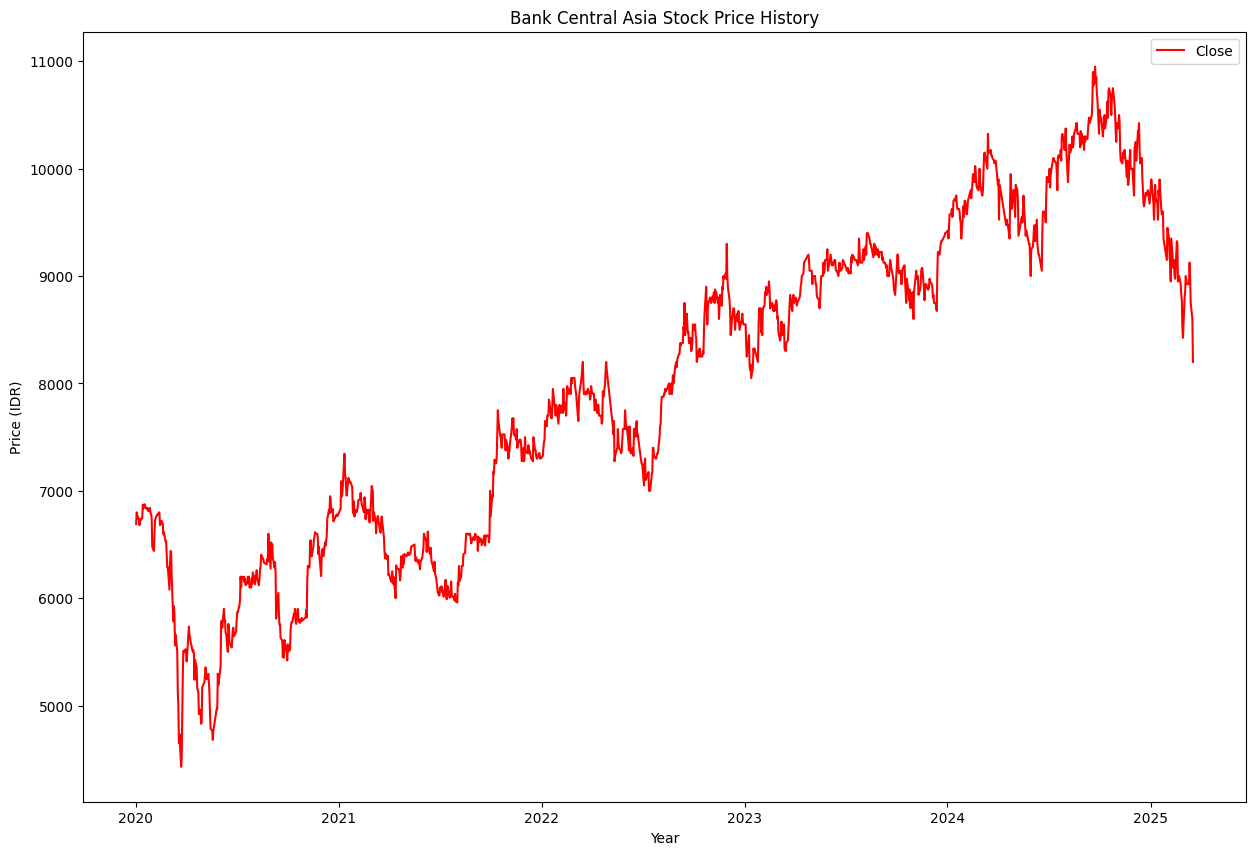

In [27]:
# plot data
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

x_dates = stock_data['Date']

plt.plot(x_dates, stock_data['Close'], 'r', label='Close')
plt.xlabel('Year')
plt.ylabel('Price (IDR)')
plt.title('Bank Central Asia Stock Price History')
plt.legend()
plt.gcf()
plt.show()

### Data Preprocessing

In [28]:
# Feature engineering: Add moving averages and returns
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
stock_data['Returns'] = stock_data['Close'].pct_change()

# Drop missing values created by rolling windows and returns
stock_data.dropna(inplace=True)

# Use relevant features for prediction
features = ['Close', 'MA_50', 'MA_200', 'Returns']
dataset = stock_data[features].values

# Scale data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences for LSTM
def create_sequences(data, look_back=60):
    x, y = [], []
    for i in range(look_back, len(data)):
        x.append(data[i-look_back:i, :])  # Use all features
        y.append(data[i, 0])  # Predict the 'Price' column
    return np.array(x), np.array(y)

# Define look-back period and create sequences
look_back = 60
x, y = create_sequences(scaled_data, look_back)

# Split data into training and testing sets
train_size = int(len(x) * 0.80)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Display dataset shapes
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((802, 60, 4), (201, 60, 4), (802,), (201,))

### Model Building

In [29]:
# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop, lr_scheduler])

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), len(features) - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), len(features) - 1))), axis=1))[:, 0]

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0314 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0054 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0038 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0033 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0033 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0035 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0027 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0022 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0020 - val_loss: 0.0052 - learning_rate: 2.0000e-04
Epoch 10/50
41

### Evaluation

In [30]:
# Evaluation metrics
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

MSE: 122061.03448514192
RMSE: 349.37234361801154
MAE: 299.1996707904398
R2 Score: 0.6250381335169684


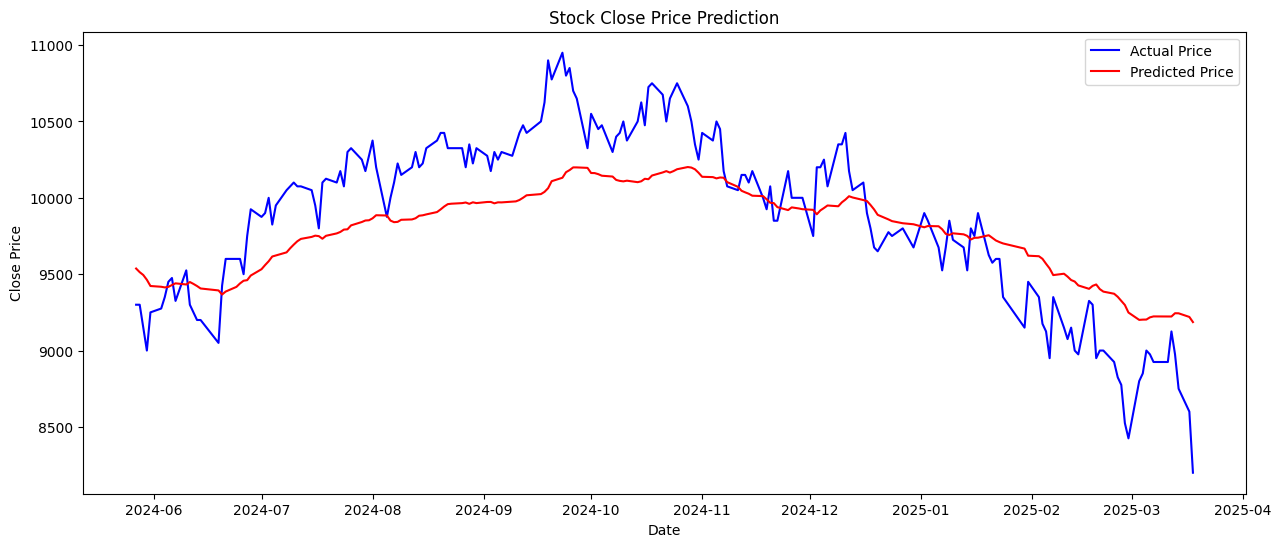

In [31]:
dates_for_plot = stock_data['Date'][train_size + look_back:]
plt.figure(figsize=(15, 6))
plt.plot(dates_for_plot, y_test_actual, label='Actual Price', color='blue')
plt.plot(dates_for_plot, predictions, label='Predicted Price', color='red')
plt.title('Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

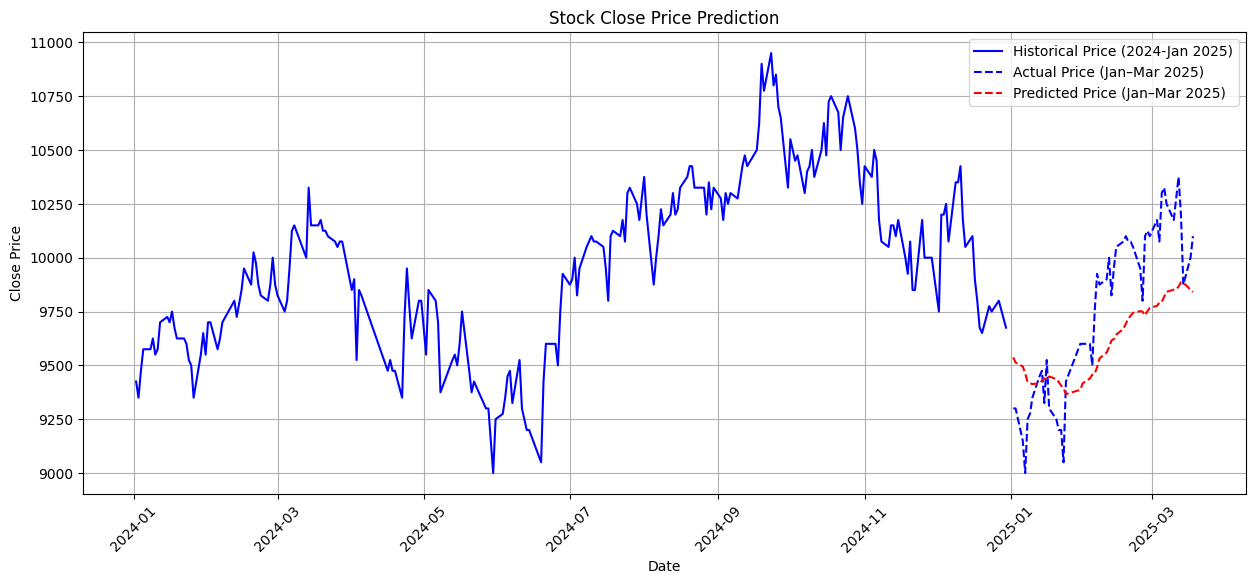

In [32]:
historical_start = '2024-01-01'  
test_start = '2025-01-01' 
test_end = '2025-03-31' 

# Extract dates for historical (2024–Jan 2025) and test (Jan–Mar 2025) data
historical_mask = (stock_data['Date'] >= historical_start) & (stock_data['Date'] < test_start)
test_mask = (stock_data['Date'] >= test_start) & (stock_data['Date'] <= test_end)

# Extract corresponding actual and predicted values
dates_historical = stock_data.loc[historical_mask, 'Date']
historical_prices = stock_data.loc[historical_mask, 'Close']

dates_test = stock_data.loc[test_mask, 'Date']
actual_prices_test = y_test_actual[:len(dates_test)]  # Ensure alignment
predicted_prices_test = predictions[:len(dates_test)]  # Ensure alignment

# Plot historical data and test data with predictions
plt.figure(figsize=(15, 6))

# Historical Data (2024 - Jan 2025)
plt.plot(dates_historical, historical_prices, label='Historical Price (2024-Jan 2025)', color='blue')

# Test Data (Actual, Jan–Mar 2025)
plt.plot(dates_test, actual_prices_test, label='Actual Price (Jan–Mar 2025)', color='blue', linestyle='dashed')

# Predictions (Jan–Mar 2025)
plt.plot(dates_test, predicted_prices_test, label='Predicted Price (Jan–Mar 2025)', color='red', linestyle='dashed')

# Labels & Styling
plt.title('Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()